In [1]:
# --- Reproducible environment & lightweight utilities ---
from __future__ import annotations

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# --- Training utilities ---
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from tqdm.auto import tqdm
import math


# Plot defaults: consistent sizing and readable grids
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 140

# Keep the console clean from non-critical warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Project paths
TRAIN_DATASET = "../data/train.csv"
TEST_DATASET = "../data/test.csv"
MODEL_PATH = "../models"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


# Data Cleaning & Alignment

Before any feature engineering or modeling, we ensure both **train** and **test** datasets share the exact same structure.  
This involves removing columns that are not available in both sets (to avoid data leakage),  
isolating the **target variable** (`trip_duration`), and preserving **ID columns** separately for evaluation and submission.

Steps:
1. Drop `dropoff_datetime` from the training data — it's unavailable in test and leaks target information.  
2. Split the target column (`trip_duration`) from the training features.  
3. Store `id` columns separately to use later when generating the submission file.  
4. Remove `id` from features (since it has no predictive value).  
5. Validate that train and test feature sets are perfectly aligned.  
This ensures both datasets are **schema-consistent**, **leak-free**, and ready for feature extraction.


In [2]:
# load dataset
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

In [3]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [4]:
df_test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [5]:
# ============================================================
# Clean alignment between train and test datasets
# ============================================================

# --- 1. Drop columns from train that do not exist in test ---
# (dropoff_datetime leaks the target information)
df_train = df_train.drop(columns=["dropoff_datetime"])
# --- 2. Separate the target variable (trip_duration) ---
target_col = "trip_duration"
y_train = df_train[target_col]
X_train = df_train.drop(columns=[target_col])
# --- 3. Keep ID columns separately for later submission/evaluation ---
train_ids = X_train["id"].copy()
test_ids = df_test["id"].copy()
# --- 4. Drop ID columns from the feature sets (not predictive) ---
X_train = X_train.drop(columns=["id"])
X_test = df_test.drop(columns=["id"])
print(f"Shapes aligned: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"Target shape: y_train={y_train.shape}")
print(f"Feature columns: {X_train.columns.tolist()}")

Shapes aligned: X_train=(1458644, 8), X_test=(625134, 8)
Target shape: y_train=(1458644,)
Feature columns: ['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']


In [6]:
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   passenger_count     1458644 non-null  int64  
 3   pickup_longitude    1458644 non-null  float64
 4   pickup_latitude     1458644 non-null  float64
 5   dropoff_longitude   1458644 non-null  float64
 6   dropoff_latitude    1458644 non-null  float64
 7   store_and_fwd_flag  1458644 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 89.0+ MB


None

In [7]:
display(X_train["store_and_fwd_flag"].unique())

array(['N', 'Y'], dtype=object)

In [8]:
# Convert the categorical flag ('N'/'Y') into a binary numeric feature (0/1)
# 'N' → 0 means no message stored/forwarded
# 'Y' → 1 means the trip record was stored and forwarded
for df in (X_train, X_test):
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"N": 0, "Y": 1}).astype(int)

In [9]:
display(X_train["pickup_datetime"].head())

0    2016-03-14 17:24:55
1    2016-06-12 00:43:35
2    2016-01-19 11:35:24
3    2016-04-06 19:32:31
4    2016-03-26 13:30:55
Name: pickup_datetime, dtype: object

In [10]:
# ============================================================
# Datetime feature engineering for pickup_datetime
# ============================================================

def add_pickup_datetime_features(df: pd.DataFrame, col: str = "pickup_datetime") -> pd.DataFrame:
    """
    Expand the pickup datetime column into a set of meaningful numerical features.

    This transformation:
    - Parses the raw timestamp into a proper datetime object.
    - Extracts calendar/time components (year, month, day, hour, minute, weekday).
    - Adds a weekend indicator.
    - Adds cyclic encodings for hour-of-day and day-of-week to capture periodic patterns.
    - Drops the original datetime column once all features are derived.

    The function returns a new DataFrame with the additional columns.
    """
    # Parse the datetime column (errors coerced to NaT to avoid hard crashes on bad rows)
    dt = pd.to_datetime(df[col], errors="coerce")

    # Basic calendar components
    df["pickup_year"] = dt.dt.year
    df["pickup_month"] = dt.dt.month
    df["pickup_day"] = dt.dt.day
    df["pickup_hour"] = dt.dt.hour
    df["pickup_minute"] = dt.dt.minute
    df["pickup_dayofweek"] = dt.dt.dayofweek  # 0 = Monday, 6 = Sunday

    # Weekend flag: 1 if Saturday/Sunday, else 0
    df["is_weekend"] = (df["pickup_dayofweek"] >= 5).astype(int)

    # Cyclic encoding for hour of day (24-hour cycle)
    df["pickup_hour_sin"] = np.sin(2 * np.pi * df["pickup_hour"] / 24)
    df["pickup_hour_cos"] = np.cos(2 * np.pi * df["pickup_hour"] / 24)

    # Cyclic encoding for day of week (7-day cycle)
    df["pickup_dow_sin"] = np.sin(2 * np.pi * df["pickup_dayofweek"] / 7)
    df["pickup_dow_cos"] = np.cos(2 * np.pi * df["pickup_dayofweek"] / 7)

    # Drop the original raw datetime column to keep the feature space purely numeric
    df = df.drop(columns=[col])

    return df

In [11]:
# Apply the same transformation to both train and test feature sets
X_train = add_pickup_datetime_features(X_train, col="pickup_datetime")
X_test = add_pickup_datetime_features(X_test, col="pickup_datetime")

In [12]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek,is_weekend,pickup_hour_sin,pickup_hour_cos,pickup_dow_sin,pickup_dow_cos
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,2016,3,14,17,24,0,0,-0.965926,-0.258819,0.000000,1.000000
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,2016,6,12,0,43,6,1,0.000000,1.000000,-0.781831,0.623490
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2016,1,19,11,35,1,0,0.258819,-0.965926,0.781831,0.623490
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,2016,4,6,19,32,2,0,-0.965926,0.258819,0.974928,-0.222521
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,2016,3,26,13,30,5,1,-0.258819,-0.965926,-0.974928,-0.222521


In [13]:
print(y_train.head())

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64


In [14]:
# Map vendor_id from {1,2} to {0,1}
for df in (X_train, X_test):
    df["vendor_id"] = df["vendor_id"].map({1: 0, 2: 1}).astype(int)

In [15]:
# ============================================================
# Split training data into train/validation subsets
# ============================================================

# We'll keep aside a small fraction for internal validation.
# This helps us tune hyperparameters and check overfitting.
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.02,             # 2% for validation
    random_state=RNG_SEED,      
    shuffle=True
)
X_train_main, X_test_from_train, y_train_main, y_test_from_train = train_test_split(
    X_train_split, y_train_split,
    test_size=0.02,
    random_state=RNG_SEED,
    shuffle=True
)

In [16]:
print("Train main:", X_train_main.shape, y_train_main.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test-from-train:", X_test_from_train.shape, y_test_from_train.shape)

Train main: (1400881, 18) (1400881,)
Val: (29173, 18) (29173,)
Test-from-train: (28590, 18) (28590,)


In [17]:
X_train_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400881 entries, 1410218 to 460979
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1400881 non-null  int64  
 1   passenger_count     1400881 non-null  int64  
 2   pickup_longitude    1400881 non-null  float64
 3   pickup_latitude     1400881 non-null  float64
 4   dropoff_longitude   1400881 non-null  float64
 5   dropoff_latitude    1400881 non-null  float64
 6   store_and_fwd_flag  1400881 non-null  int64  
 7   pickup_year         1400881 non-null  int32  
 8   pickup_month        1400881 non-null  int32  
 9   pickup_day          1400881 non-null  int32  
 10  pickup_hour         1400881 non-null  int32  
 11  pickup_minute       1400881 non-null  int32  
 12  pickup_dayofweek    1400881 non-null  int32  
 13  is_weekend          1400881 non-null  int64  
 14  pickup_hour_sin     1400881 non-null  float64
 15  pickup_hour_cos

In [18]:
# ============================================================
# Drop redundant or uninformative datetime columns
# ============================================================

cols_to_drop = ["pickup_year", "pickup_hour", "pickup_dayofweek"]

for df in (X_train_main, X_val, X_test_from_train, X_test):
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Dropped redundant columns:", cols_to_drop)
print("Remaining feature count:", X_train_main.shape[1])
print("Feature columns now aligned across all datasets.")

Dropped redundant columns: ['pickup_year', 'pickup_hour', 'pickup_dayofweek']
Remaining feature count: 15
Feature columns now aligned across all datasets.


In [19]:
# ============================================================
# Geo distance & direction features (Haversine, Manhattan, Bearing)
# ============================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the great-circle distance between two points on Earth (in km).
    """
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))


def manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Approximate 'Manhattan' distance as sum of lat and lon movements (in km).
    Useful for grid-like city layouts such as NYC.
    """
    return (
        haversine_distance(lat1, lon1, lat1, lon2) +
        haversine_distance(lat1, lon1, lat2, lon1)
    )


def bearing_angle(lat1, lon1, lat2, lon2):
    """
    Compute bearing angle (direction) from pickup to dropoff in degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    return np.degrees(np.arctan2(y, x))


for df in (X_train_main, X_val, X_test_from_train, X_test):
    # Core distances
    df["haversine_km"] = haversine_distance(
        df["pickup_latitude"], df["pickup_longitude"],
        df["dropoff_latitude"], df["dropoff_longitude"]
    )
    df["manhattan_km"] = manhattan_distance(
        df["pickup_latitude"], df["pickup_longitude"],
        df["dropoff_latitude"], df["dropoff_longitude"]
    )

    # Direction as cyclic features
    bearing_deg = bearing_angle(
        df["pickup_latitude"], df["pickup_longitude"],
        df["dropoff_latitude"], df["dropoff_longitude"]
    )
    rad = np.radians(bearing_deg)
    df["bearing_sin"] = np.sin(rad)
    df["bearing_cos"] = np.cos(rad)

print("Added haversine_km, manhattan_km, bearing_sin, bearing_cos features.")
print("New Train main shape:", X_train_main.shape)


Added haversine_km, manhattan_km, bearing_sin, bearing_cos features.
New Train main shape: (1400881, 19)


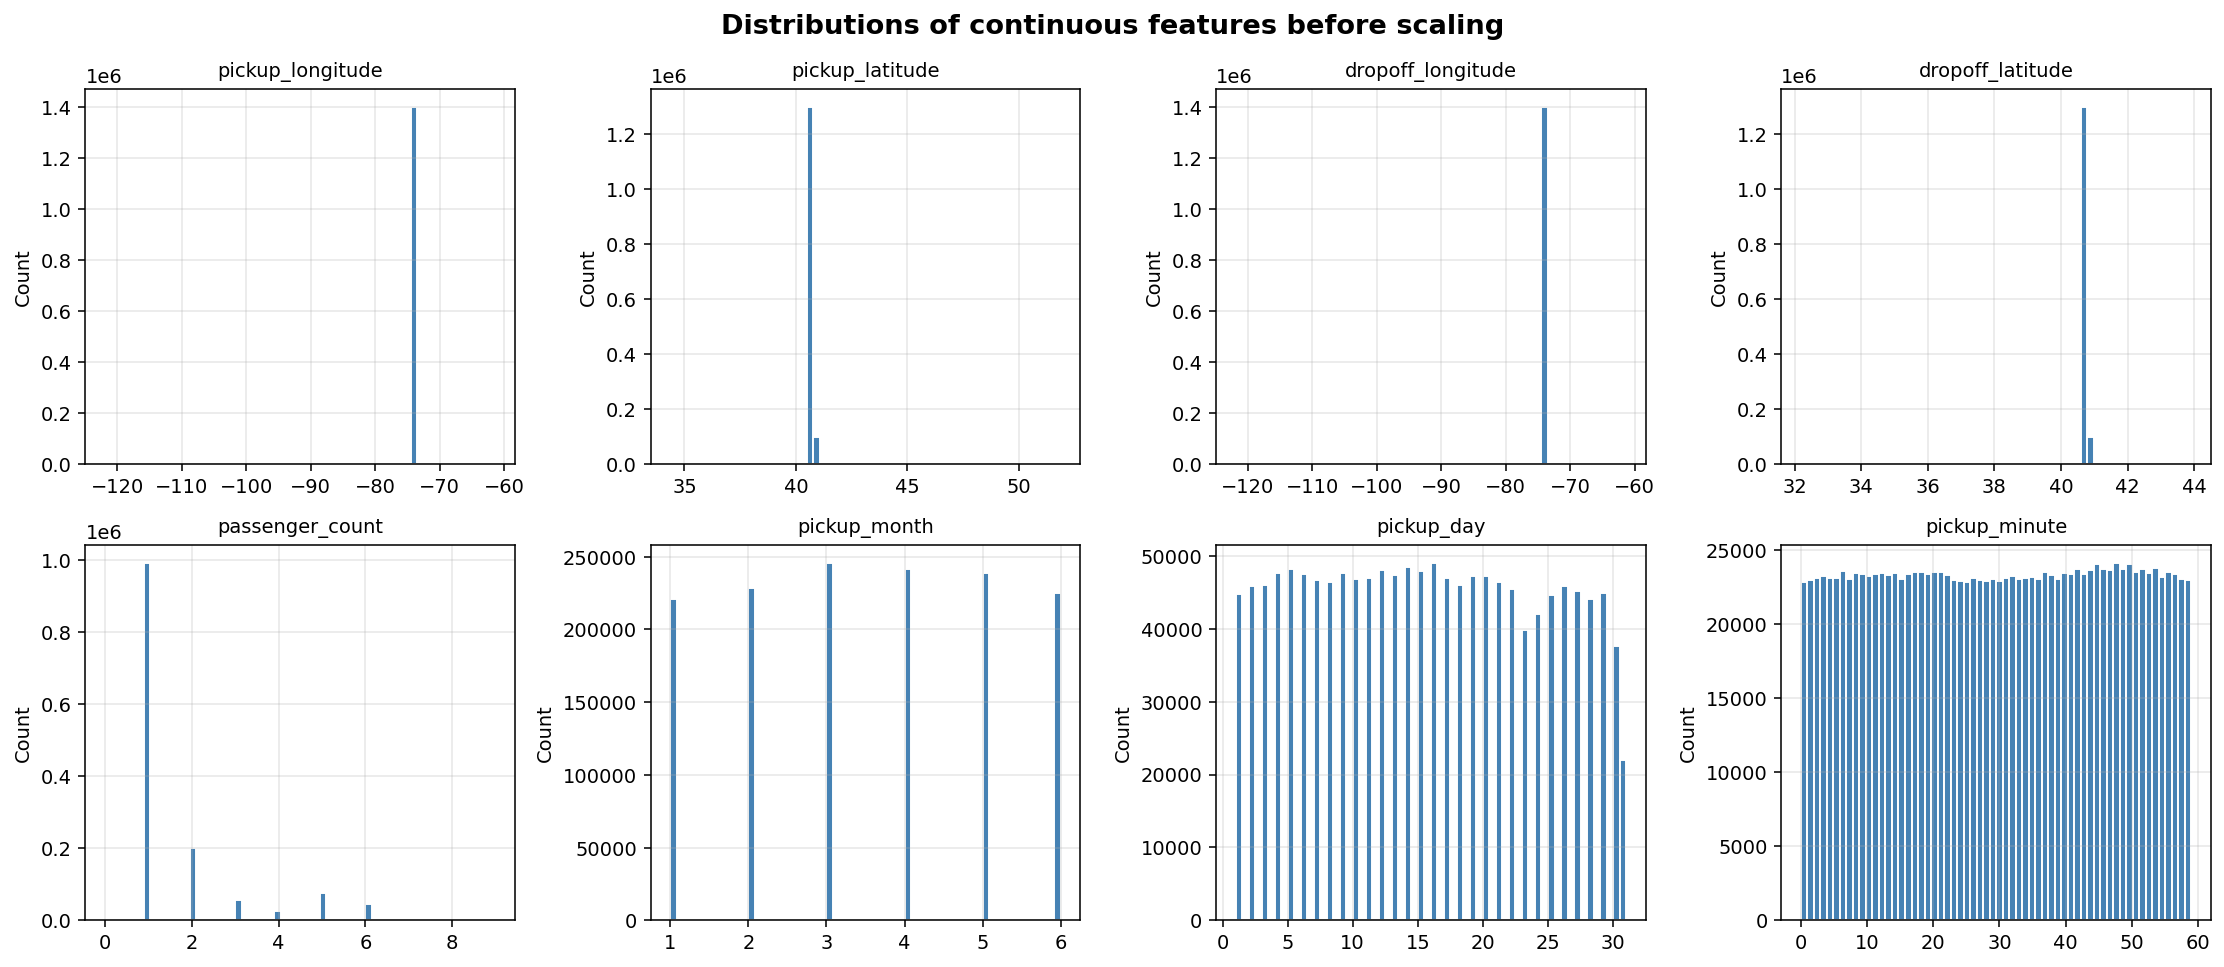

In [20]:
# ============================================================
# Quick visualization of numeric feature distributions
# ============================================================
cols_to_plot = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "passenger_count", "pickup_month",
    "pickup_day", "pickup_minute"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    ax.hist(X_train_main[col], bins=60, color="steelblue", edgecolor="white")
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")  # clean layout
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)

fig.suptitle("Distributions of continuous features before scaling", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


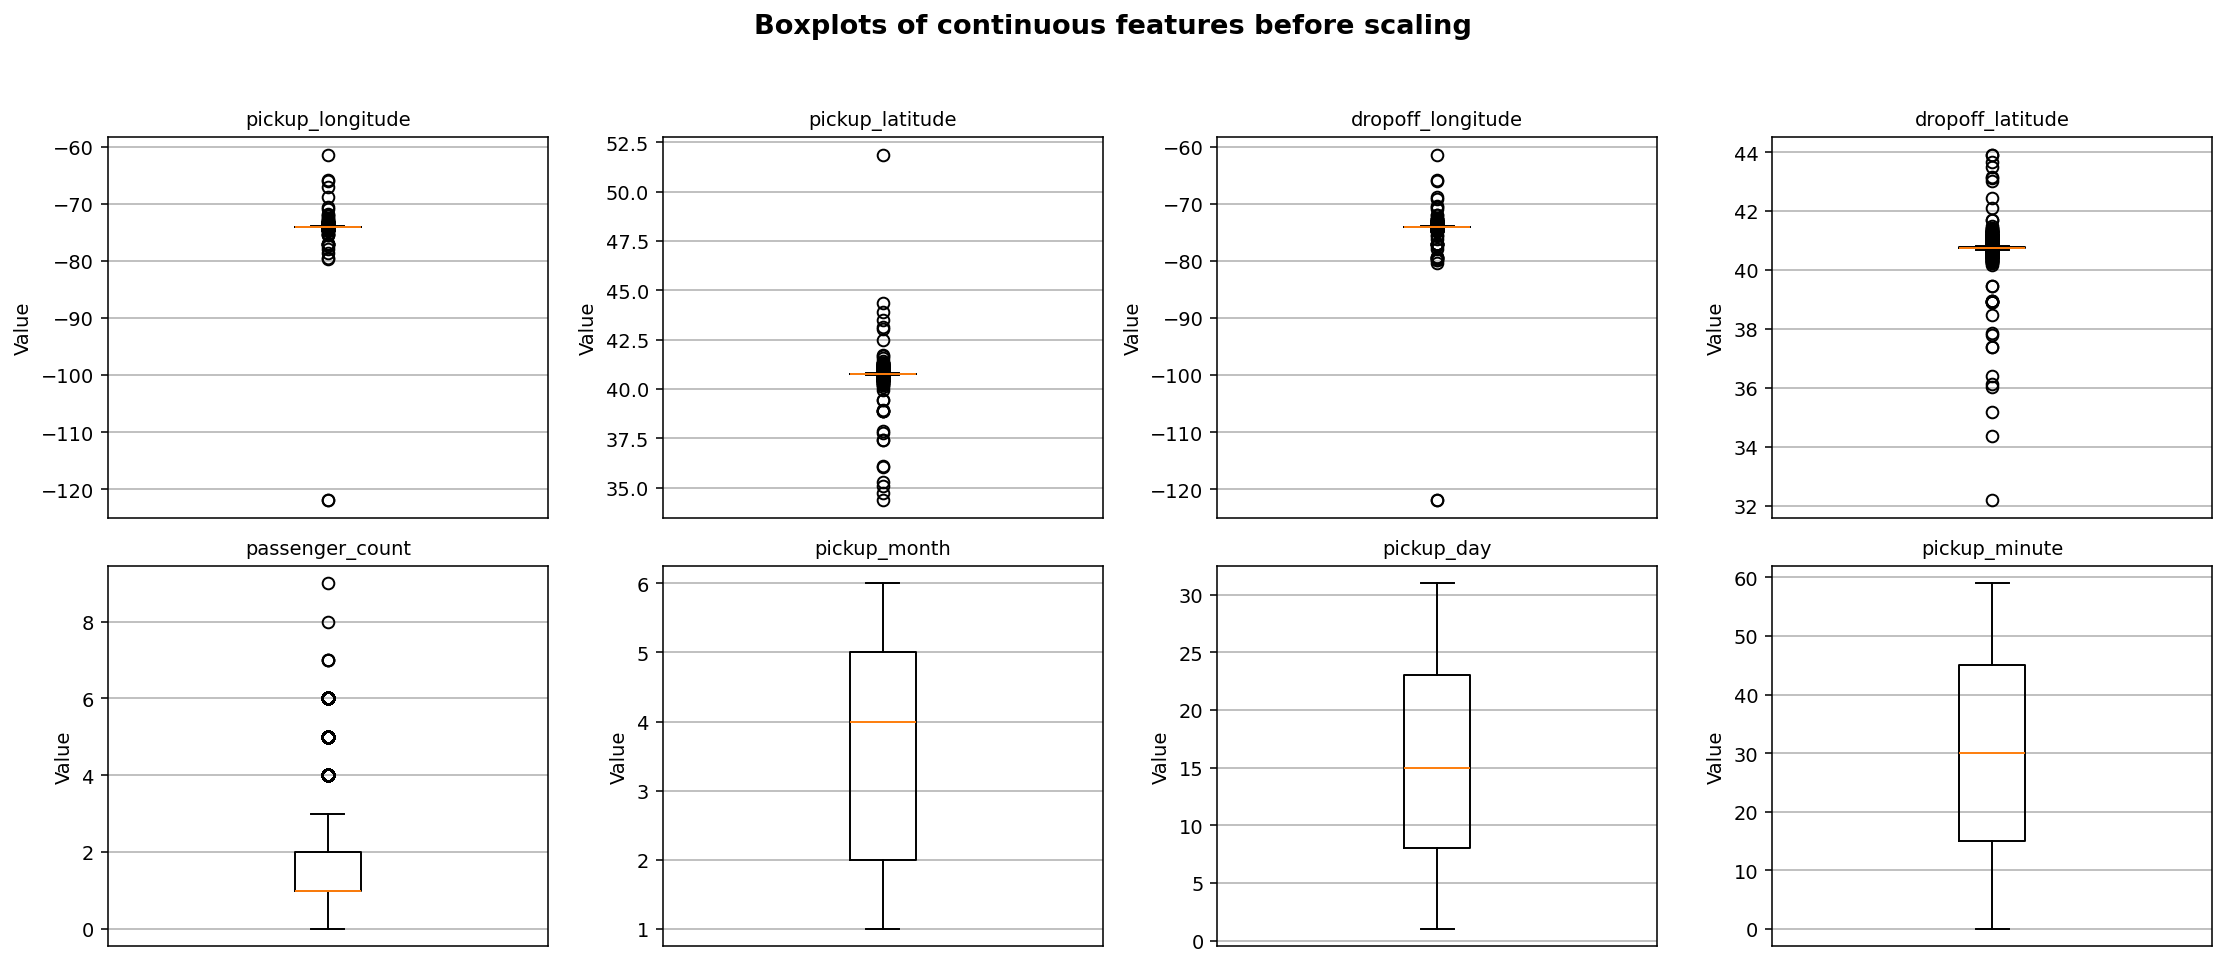

In [21]:
# ============================================================
# Boxplots of numeric feature distributions
# ============================================================
cols_to_plot = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "passenger_count", "pickup_month",
    "pickup_day", "pickup_minute"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    ax.boxplot(X_train_main[col].dropna(), vert=True, showfliers=True)
    ax.set_title(col, fontsize=10)
    ax.set_xticks([])          # sin labels en el eje x (solo una caja)
    ax.set_ylabel("Value")

fig.suptitle("Boxplots of continuous features before scaling", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
# ============================================================
# Custom transformers
# ============================================================
class QuantileClipper(BaseEstimator, TransformerMixin):
    """
    Per-column winsorization: clip each feature to [q_low, q_high] based on
    empirical quantiles computed on the training data.

    Useful for heavy-tailed continuous features and to reduce the influence of
    extreme outliers without fully discarding samples.
    """
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.nanquantile(X, self.low, axis=0)
        self.q_high_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)


class ValueClipper(BaseEstimator, TransformerMixin):
    """
    Clip all values to a fixed [min_val, max_val] range.
    Intended for variables with known plausible bounds.
    """
    def __init__(self, min_val=None, max_val=None):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.min_val is not None:
            X = np.maximum(X, self.min_val)
        if self.max_val is not None:
            X = np.minimum(X, self.max_val)
        return X
    
# ============================================================
# Column groups (updated with geo distance & bearing)
# ============================================================

ALL_FEATURES = list(X_train_main.columns)

# Binary features (already 0/1)
BINARY_COLS = ["vendor_id", "store_and_fwd_flag", "is_weekend"]

# Cyclic features (already in [-1, 1]):
# - pickup hour
# - day of week
# - bearing direction
CYCLIC_COLS = [
    "pickup_hour_sin", "pickup_hour_cos",
    "pickup_dow_sin", "pickup_dow_cos",
    "bearing_sin", "bearing_cos",
]

# Continuous / discrete numeric features to scale
GEO_LON_COLS = ["pickup_longitude", "dropoff_longitude"]
GEO_LAT_COLS = ["pickup_latitude", "dropoff_latitude"]
PASSENGER_COL = ["passenger_count"]
DATE_DISCRETE_COLS = ["pickup_month", "pickup_day", "pickup_minute"]

# New distance-based features
DIST_COLS = ["haversine_km", "manhattan_km"]

NUMERIC_COLS = GEO_LON_COLS + GEO_LAT_COLS + PASSENGER_COL + DATE_DISCRETE_COLS + DIST_COLS

# Sanity check: ensure all features are assigned to some group
covered = set(BINARY_COLS + CYCLIC_COLS + NUMERIC_COLS)
missing = set(ALL_FEATURES) - covered
assert not missing, f"Unhandled feature columns: {missing}"

# ============================================================
# Pipelines for each block
# ============================================================

# Longitudes: clip to a plausible NYC bounding box, winsorize tails, robust scale
geo_lon_pipe = Pipeline(steps=[
    ("clip_bbox", ValueClipper(min_val=-74.3, max_val=-73.5)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Latitudes: same idea with appropriate bounds
geo_lat_pipe = Pipeline(steps=[
    ("clip_bbox", ValueClipper(min_val=40.5, max_val=41.0)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Passenger count: enforce [1, 6] and scale
passenger_pipe = Pipeline(steps=[
    ("clip", ValueClipper(min_val=1, max_val=6)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Discrete calendar features: simple robust scaling is enough
date_pipe = Pipeline(steps=[
    ("scaler", RobustScaler()),
])

dist_pipe = Pipeline(steps=[
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# ============================================================
# Main ColumnTransformer
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("geo_lon", geo_lon_pipe, GEO_LON_COLS),
        ("geo_lat", geo_lat_pipe, GEO_LAT_COLS),
        ("passenger", passenger_pipe, PASSENGER_COL),
        ("date_disc", date_pipe, DATE_DISCRETE_COLS),
        ("dist", dist_pipe, DIST_COLS),
        ("binary", "passthrough", BINARY_COLS),
        ("cyclic", "passthrough", CYCLIC_COLS),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ============================================================
# Fit on train_main, apply to all splits
# ============================================================

X_train_main_t = preprocess.fit_transform(X_train_main)
X_val_t = preprocess.transform(X_val)
X_test_from_train_t = preprocess.transform(X_test_from_train)
X_test_t = preprocess.transform(X_test)

print("Transformed shapes:")
print("  Train main:", X_train_main_t.shape)
print("  Val:", X_val_t.shape)
print("  Test-from-train:", X_test_from_train_t.shape)
print("  Kaggle test:", X_test_t.shape)

# ============================================================
# Target transformation (log1p for trip_duration)
# ============================================================

# We train the regression model on log1p(trip_duration) to stabilize the loss
# and reduce the impact of extremely long trips.
y_train_main_log = np.log1p(y_train_main.values)
y_val_log = np.log1p(y_val.values)
y_test_from_train_log = np.log1p(y_test_from_train.values)

print("Target transformed with log1p().")

Transformed shapes:
  Train main: (1400881, 19)
  Val: (29173, 19)
  Test-from-train: (28590, 19)
  Kaggle test: (625134, 19)
Target transformed with log1p().


## PyTorch data pipeline: tensors, Dataset, and DataLoader
Convert transformed NumPy arrays to PyTorch tensors (float32 for features, int64 for labels).
Wrap them in a minimal Dataset for tabular data.
Create DataLoaders:
shuffle=True only for training.
A reasonable batch_size for stable updates.

In [23]:
# ----------------------------
# 1) Convert NumPy arrays to tensors
# ----------------------------

# Features: always float32
x_train = X_train_main_t.astype(np.float32)
x_val = X_val_t.astype(np.float32)
x_test_from_train = X_test_from_train_t.astype(np.float32)
x_test = X_test_t.astype(np.float32)

# Targets (log1p(trip_duration)): regression → float32
y_train = y_train_main_log.astype(np.float32)
y_val = y_val_log.astype(np.float32)
y_test_from_train = y_test_from_train_log.astype(np.float32)


# ----------------------------
# 2) Supervised Dataset for regression
# ----------------------------

class TabularDataset(Dataset):
    """
    Thin dataset wrapper for supervised tabular regression.

    Expects:
    - X: NumPy array of shape [N, D], float32
    - y: NumPy array of shape [N], float32 (log-transformed target here)
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0], "Features and targets must have the same number of rows."
        self.X = torch.from_numpy(X)  # [N, D], float32
        self.y = torch.from_numpy(y)  # [N], float32

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


# ----------------------------
# 3) Inference-only Dataset for Kaggle test
# ----------------------------

class TabularTestDataset(Dataset):
    """
    Dataset wrapper for inference on unlabeled tabular data (Kaggle test set).
    Returns only feature tensors.
    """
    def __init__(self, X: np.ndarray):
        self.X = torch.from_numpy(X.astype(np.float32))

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        return self.X[idx]


# ----------------------------
# 4) Instantiate datasets
# ----------------------------

train_ds = TabularDataset(x_train, y_train)
val_ds = TabularDataset(x_val, y_val)
test_from_train_ds = TabularDataset(x_test_from_train, y_test_from_train)
test_ds = TabularTestDataset(x_test)  # Kaggle test (no targets)
# ----------------------------
# 5) DataLoaders
# ----------------------------

BATCH_SIZE = 2048  # can tune later

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,       # shuffle only for training
    drop_last=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

test_from_train_loader = DataLoader(
    test_from_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print("   DataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test-from-train batches: {len(test_from_train_loader)}")
print(f"  Kaggle test batches: {len(test_loader)}")

   DataLoaders ready:
  Train batches: 685
  Val batches: 15
  Test-from-train batches: 14
  Kaggle test batches: 306


## Model & training setup

In [24]:
device = DEVICE
# ---- Model ----
INPUT_DIM = x_train.shape[1]  
HIDDEN = [64, 32, 16, 16]               
DROPOUT = 0.3

class TabularMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: list[int], dropout: float = 0.2):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden # dims is a list containing the number of neurons of each layer that we will chain together.
        for i in range(len(dims) - 1): # 0 -> (len(dims) - 1) 
            layers += [
                nn.Linear(dims[i], dims[i+1]), # dense connection (linear combination of inputs)
                nn.BatchNorm1d(dims[i+1]),     # normalizes activations (improves stability)
                nn.GELU(),                     # non-linearity
                nn.Dropout(dropout),           # randomly drops neurons (regularization to prevent overfitting)
            ]
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(hidden[-1] if hidden else in_dim, 1) # regression output
        # careful weight initialization
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m: nn.Module):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(self.backbone) > 0:
            x = self.backbone(x)
        out = self.head(x)  # shape [B, 1]
        return out.squeeze(-1)      # [B]

model = TabularMLP(INPUT_DIM, HIDDEN, DROPOUT).to(device)

# ---- Loss ----
criterion = nn.MSELoss()

# ---- Optimizer ----
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [25]:
# ============================================================
# Training loop with validation, early stopping & loss curves
# ============================================================
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int = 30,
    patience: int = 5,
):
    """
    Generic training loop for tabular regression with early stopping and loss tracking.

    Args:
        model: PyTorch model (e.g. TabularMLP)
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        criterion: loss function (e.g. nn.MSELoss)
        optimizer: optimizer (e.g. AdamW)
        device: CPU or CUDA device
        num_epochs: max epochs to train
        patience: early stopping patience (epochs without improvement)

    Returns:
        model: best model (weights reloaded)
        history: dict with train/val losses per epoch
    """
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # -------------------------
        # Training phase
        # -------------------------
        model.train()
        running_loss = 0.0

        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # -------------------------
        # Validation phase
        # -------------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)

        val_loss /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)

        # -------------------------
        # Logging & early stopping
        # -------------------------
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

        # Track best model
        if val_loss < best_val_loss - 1e-5:  # small tolerance
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch}")
            break

    # -------------------------
    # Load best model weights
    # -------------------------
    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"\n✅ Training finished. Best Val Loss: {best_val_loss:.5f}")

    # -------------------------
    # Plot loss curves
    # -------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(history["train_loss"], label="Train Loss", linewidth=2)
    plt.plot(history["val_loss"], label="Val Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return model, history


Epoch 1/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 15.98010 | Val Loss: 1.98132


Epoch 2/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 3.14528 | Val Loss: 1.12986


Epoch 3/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 2.31691 | Val Loss: 0.72194


Epoch 4/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 1.83201 | Val Loss: 0.50100


Epoch 5/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 1.48440 | Val Loss: 0.34562


Epoch 6/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 1.23551 | Val Loss: 0.28107


Epoch 7/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 1.05519 | Val Loss: 0.28453


Epoch 8/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.92041 | Val Loss: 0.24978


Epoch 9/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.81152 | Val Loss: 0.24249


Epoch 10/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.71608 | Val Loss: 0.22935


Epoch 11/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.62423 | Val Loss: 0.23310


Epoch 12/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.54270 | Val Loss: 0.22582


Epoch 13/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.46715 | Val Loss: 0.22344


Epoch 14/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.39983 | Val Loss: 0.21772


Epoch 15/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.34825 | Val Loss: 0.21136


Epoch 16/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.30579 | Val Loss: 0.21104


Epoch 17/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.27553 | Val Loss: 0.20617


Epoch 18/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.25624 | Val Loss: 0.20588


Epoch 19/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.24395 | Val Loss: 0.20204


Epoch 20/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.23792 | Val Loss: 0.20065


Epoch 21/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.23452 | Val Loss: 0.19745


Epoch 22/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.23175 | Val Loss: 0.19749


Epoch 23/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.23036 | Val Loss: 0.19746


Epoch 24/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.22892 | Val Loss: 0.19637


Epoch 25/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.22741 | Val Loss: 0.19401


Epoch 26/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.22643 | Val Loss: 0.19455


Epoch 27/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.22511 | Val Loss: 0.19468


Epoch 28/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.22424 | Val Loss: 0.19257


Epoch 29/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.22365 | Val Loss: 0.19329


Epoch 30/30:   0%|          | 0/685 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.22307 | Val Loss: 0.19046

✅ Training finished. Best Val Loss: 0.19046


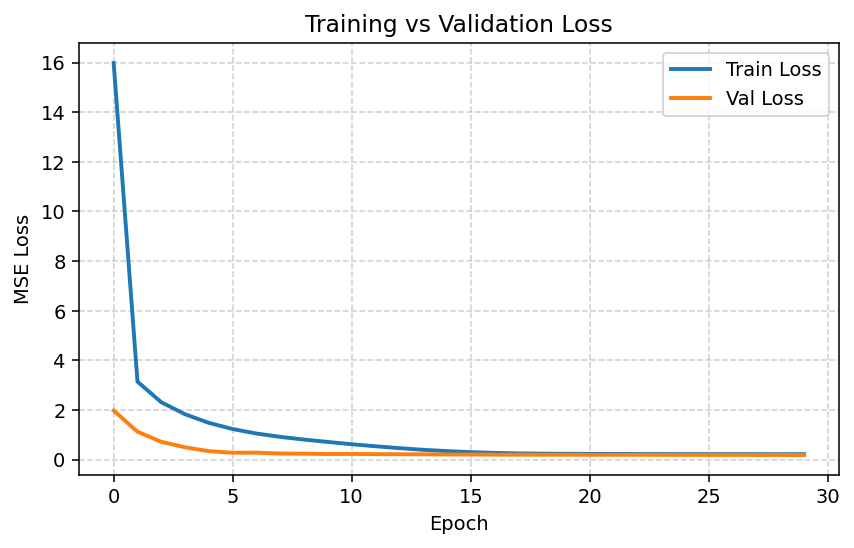

In [26]:
# ============================================================
# Training
# ============================================================
NUM_EPOCHS = 30
PATIENCE = 5

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
)

In [27]:
torch.save(model.state_dict(), "../models/best_tabular_mlp.pt")

In [28]:
rmse = np.sqrt(min(history["val_loss"]))
print(f"Validation RMSE (log1p space): {rmse:.4f}")

Validation RMSE (log1p space): 0.4364


In [29]:
model.eval()
preds_test, y_true = [], []

with torch.no_grad():
    for xb, yb in test_from_train_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).cpu().numpy()
        preds_test.append(preds)
        y_true.append(yb.numpy())

preds_test = np.concatenate(preds_test)
y_true = np.concatenate(y_true)

# RMSE en log-space
test_rmse_log = np.sqrt(np.mean((preds_test - y_true) ** 2))
print(f"Test-from-train RMSE (log1p space): {test_rmse_log:.4f}")


Test-from-train RMSE (log1p space): 0.4265


In [30]:
preds_real = np.expm1(preds_test)
y_true_real = np.expm1(y_true)

# RMSE real (en seg)
test_rmse_real = np.sqrt(np.mean((preds_real - y_true_real) ** 2))
print(f"Test-from-train RMSE (real seconds): {test_rmse_real:.2f}")


Test-from-train RMSE (real seconds): 12423.12


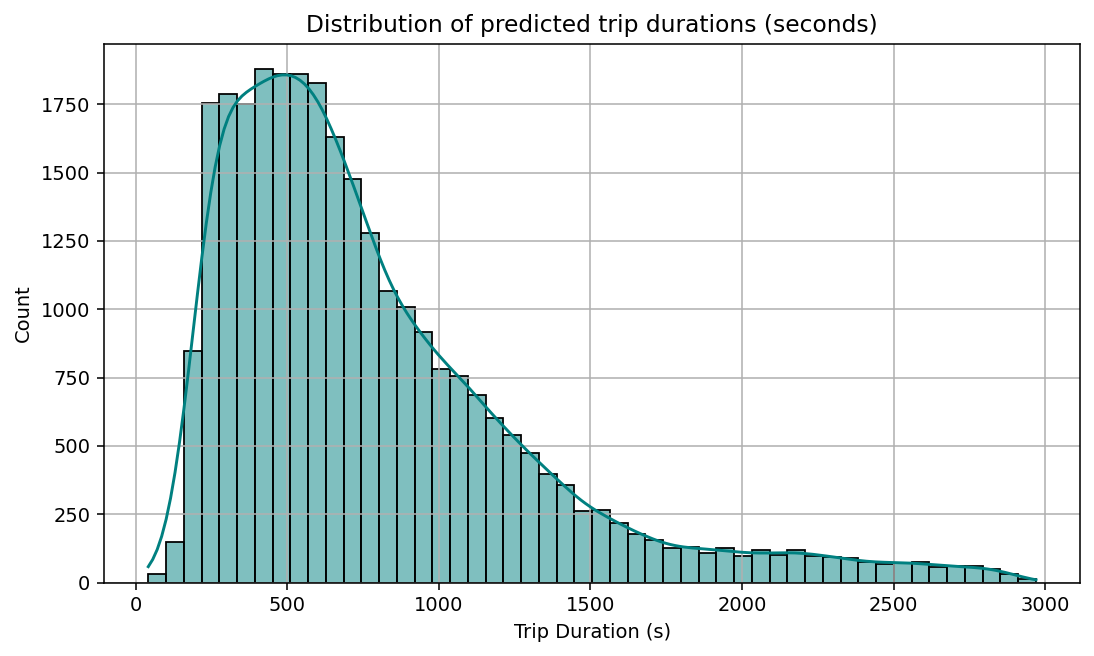

In [31]:
sns.histplot(preds_real, bins=50, kde=True, color="teal")
plt.title("Distribution of predicted trip durations (seconds)")
plt.xlabel("Trip Duration (s)")
plt.show()

In [32]:
# ============================================================
# Inference on Kaggle test set & submission file generation
# ============================================================

model.eval()

all_preds_log = []

with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(DEVICE)
        preds_log = model(xb)                 # [B] in log1p(trip_duration) space
        all_preds_log.append(preds_log.cpu().numpy())

# Concatenate all batches into a single vector
all_preds_log = np.concatenate(all_preds_log, axis=0)

# Convert back from log1p space to real trip_duration in seconds
all_preds = np.expm1(all_preds_log)

# Build submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,
    "trip_duration": all_preds
})

print(" Submission preview:")
display(submission.head())

# Save to disk
SUBMISSION_PATH = "../data/submission_mlp_baseline.csv"
submission.to_csv(SUBMISSION_PATH, index=False)
print(f"Submission file written to: {SUBMISSION_PATH}")


 Submission preview:


,id,trip_duration
0,id3004672,773.571411
1,id3505355,655.330688
2,id1217141,517.919617
3,id2150126,1040.636475
4,id1598245,370.910248


Submission file written to: ../data/submission_mlp_baseline.csv
